## Install and import

In [1]:
!pip install sentencepiece
!pip install tf_sentencepiece
!pip install fastai==1.0.52

     |████████████████████████████████| 1.2 MB 5.4 MB/s 
     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 219 kB 5.2 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=ccfafbdc6a3d1236f2f5a681b345b0de1307d840530b19ae8d2bf20be7f5cd25
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
import re
import sentencepiece as spm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
kfold16 = path/'Thesis Data'/'kfold'/'baad16'
kfold6 = path/'Thesis Data'/'kfold'/'baad6'

### BAAD16

In [5]:
baad16 = pd.read_csv(aa/'full.csv')
len(baad16)

17966

## Load sentence piece

In [6]:
vocab_size = 30000
model_prefix = news/'sp'

In [7]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [8]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix)

In [9]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])
sp_vocab = Vocab(itos)
len(itos)

30000

## Utils

In [10]:
def testing(df, classifier):
  # df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = classifier.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  acc = count/tst
  print("Accuracy: ")
  print(acc)
  print(err)
  return final_preds, targets, err, acc

In [11]:
bs = 32
bptt = 70
moms = (0.8,0.7)

## BAAD16 K-fold

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
accuracies = []
f1_scores = []
predictions = []
targets = []
errors = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
splits = skf.split(baad16[['text']], baad16[['label']])

In [14]:
# help(EarlyStoppingCallback)

In [15]:
def train_one_split(train_index, test_index, skip_first=False, min_grad_lr=None, force_lr=False):
  
  ## skip_first=True skips the first 6 epochs, and loads from saved model
  ## if skip_first=True, you need to give the previous learning rate (min_grad_lr) as a fall back for when automatic lr cannot be found
  ## if force_lr = True, use min_grad_lr

  X_train, X_test = baad16[['text']].loc[train_index], baad16[['text']].loc[test_index]
  y_train, y_test = baad16[['label']].loc[train_index], baad16[['label']].loc[test_index]
  train_df = pd.concat([X_train,y_train], axis=1)
  test_df = pd.concat([X_test,y_test], axis=1)

  train_df, valid_df = train_test_split(train_df, test_size=0.25, stratify=train_df['label'], random_state=666)
  ln_train = len(train_df)
  ln_valid = len(valid_df)
  ln_test = len(test_df)
  ln_total = ln_train + ln_valid + ln_test
  print("TRAIN len:", ln_train, "VALID len:", ln_valid, "TEST len:", ln_test, 
        "VALID percent:", np.round(ln_valid*100/ln_total,3),
        "TEST percent:", np.round(ln_test*100/ln_total,3))
  
  ## SET UP DATA
  data_clas = TextClasDataBunch.from_df(path=kfold16, train_df=train_df,valid_df=valid_df,
                                        tokenizer=mycust_tok,vocab=sp_vocab,bs=bs,text_cols='text',label_cols='label')
  learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
  
  ## TRAIN CLASSIFIER 10 EPOCHS
  if not skip_first:
    learn_cls.load_encoder(aa/'models'/'AA_subword_lm_enc') ## model pre-trained on news dataset, then finetuned on AA dataset
    learn_cls.freeze()
    learn_cls.lr_find()
    learn_cls.recorder.plot(suggestion=True)
    min_grad_lr = learn_cls.recorder.min_grad_lr
    # min_grad_lr = 1.32E-06
    learn_cls.fit_one_cycle(2, min_grad_lr, moms=moms) # learn_cls.save('')

    learn_cls.freeze_to(-2)
    learn_cls.fit_one_cycle(2 , slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)

    learn_cls.freeze_to(-3)
    learn_cls.fit_one_cycle(2 , slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)
    learn_cls.save(kfold16/'kfold_baad16_6epochs')
    print("Saved 6 epoch checkpoint.")
    return

  learn_cls.load(kfold16/'kfold_baad16_6epochs')
  print("Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.")
  learn_cls.unfreeze()
  if not force_lr:
    try:
      learn_cls.lr_find()
      learn_cls.recorder.plot(suggestion=True)
      min_grad_lr = learn_cls.recorder.min_grad_lr
    except:
      pass
  learn_cls.fit_one_cycle(20, slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms, 
                          callbacks=[EarlyStoppingCallback(learn_cls, monitor='accuracy', patience=2, min_delta=0.0001)]
                          )

  ## TESTING
  preds, targs, err, acc = testing(test_df, learn_cls)
  f1 = f1_score(targs, preds, average='weighted')

  ## SAVING RESULTS
  accuracies.append(acc)
  f1_scores.append(f1)
  predictions.append(preds)
  targets.append(targs)
  errors.append(err)

  print(acc, f1)

TRAIN len: 10779 VALID len: 3593 TEST len: 3594 VALID percent: 19.999 TEST percent: 20.004


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.158147,0.061593,0.984971,13:28
1,0.070251,0.029416,0.992207,13:48


epoch,train_loss,valid_loss,accuracy,time
0,0.201977,0.108477,0.969663,15:32
1,0.036484,0.028333,0.993320,15:53


epoch,train_loss,valid_loss,accuracy,time
0,0.214052,0.132585,0.958530,22:38
1,0.053692,0.026141,0.993320,22:41


Saved 6 epoch checkpoint.
Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


TypeError: ignored

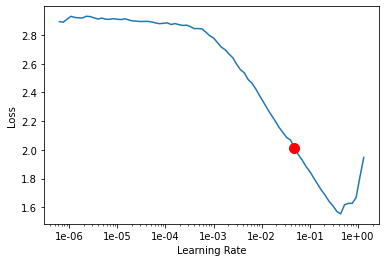

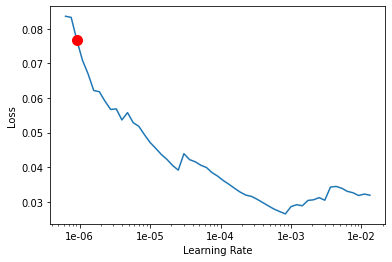

In [ ]:
## 1
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 10779 VALID len: 3593 TEST len: 3594 VALID percent: 19.999 TEST percent: 20.004


Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


epoch,train_loss,valid_loss,accuracy,time
0,0.050319,0.019571,0.995825,30:47
1,0.053648,0.018109,0.996104,30:26
2,0.036025,0.018430,0.996104,29:51
3,0.051424,0.018681,0.996104,30:08


Epoch 4: early stopping
3594
Accuracy: 
0.994991652754591
[('manik_bandhopaddhay', 'shirshendu'), ('manik_bandhopaddhay', 'shirshendu'), ('bongkim', 'shorotchandra'), ('bongkim', 'shorotchandra'), ('bongkim', 'shorotchandra'), ('MZI', 'shunil_gongopaddhay'), ('shordindu', 'shorotchandra'), ('shottojit_roy', 'robindronath'), ('shottojit_roy', 'shordindu'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shirshendu'), ('humayun_ahmed', 'zahir_rayhan'), ('humayun_ahmed', 'shorotchandra'), ('shomresh', 'shunil_gongopaddhay'), ('tarashonkor', 'nihar_ronjon_gupta'), ('bongkim', 'shorotchandra'), ('nihar_ronjon_gupta', 'shomresh')]
0.994991652754591 0.9949908150139755


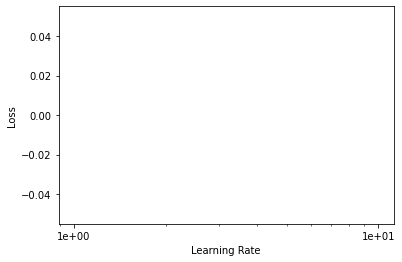

In [ ]:
## if training fails after 6 epochs, run this
train_index, test_index = next(splits) ## dont run if running on the same runtime as previous cell
train_one_split(train_index, test_index, skip_first=True, min_grad_lr=9.12E-07)

TRAIN len: 10779 VALID len: 3593 TEST len: 3594 VALID percent: 19.999 TEST percent: 20.004


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.169925,0.077318,0.983858,13:31
1,0.051096,0.024313,0.994712,13:42


epoch,train_loss,valid_loss,accuracy,time
0,0.178122,0.049869,0.990537,15:38
1,0.041655,0.014914,0.998330,15:48


epoch,train_loss,valid_loss,accuracy,time
0,0.230636,0.075543,0.989146,22:47
1,0.047620,0.022254,0.996660,22:11


Saved 6 epoch checkpoint.
Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


epoch,train_loss,valid_loss,accuracy,time
0,0.017152,0.025861,0.995547,27:54
1,0.023325,1.187804,0.995825,28:42
2,0.026344,0.256812,0.995825,27:50
3,0.019948,0.424552,0.995825,27:53
4,0.025706,0.520529,0.996104,28:22


epoch,train_loss,valid_loss,accuracy,time
0,0.017152,0.025861,0.995547,27:54
1,0.023325,1.187804,0.995825,28:42
2,0.026344,0.256812,0.995825,27:50
3,0.019948,0.424552,0.995825,27:53
4,0.025706,0.520529,0.996104,28:22
5,0.023604,0.113349,0.994712,27:51
6,0.024604,0.080016,0.995825,28:22


Epoch 7: early stopping
3594
Accuracy: 
0.9938786867000556
[('MZI', 'humayun_ahmed'), ('shordindu', 'robindronath'), ('shottojit_roy', 'shordindu'), ('zahir_rayhan', 'shorotchandra'), ('zahir_rayhan', 'shorotchandra'), ('zahir_rayhan', 'shorotchandra'), ('zahir_rayhan', 'shorotchandra'), ('zahir_rayhan', 'shorotchandra'), ('zahir_rayhan', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'shorotchandra'), ('shirshendu', 'tarashonkor'), ('shomresh', 'shottojit_roy'), ('shunil_gongopaddhay', 'MZI'), ('tarashonkor', 'shottojit_roy'), ('tarashonkor', 'shottojit_roy'), ('manik_bandhopaddhay', 'shomresh'), ('zahir_rayhan', 'shorotchandra'), ('humayun_ahmed', 'tarashonkor'), ('shirshendu', 'MZI')]
0.9938786867000556 0.993805725572687


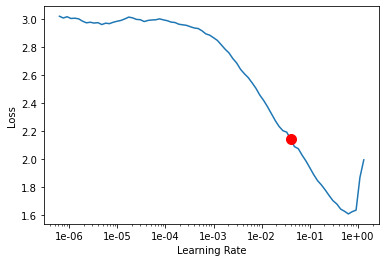

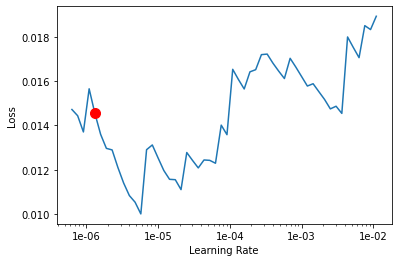

In [ ]:
## 2
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

In [ ]:
## 3
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.124962,0.045831,0.991096,14:29
1,0.059358,0.038425,0.992209,14:10


epoch,train_loss,valid_loss,accuracy,time
0,0.080372,0.044939,0.991374,16:51
1,0.018071,0.031436,0.994713,16:52


epoch,train_loss,valid_loss,accuracy,time
0,0.067619,0.034361,0.992487,24:05
1,0.034587,0.020533,0.995548,24:15


Saved 6 epoch checkpoint.
Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.018779,0.020404,0.996105,30:29
1,0.019915,0.021773,0.995548,30:22
2,0.010766,0.022303,0.995548,31:18


In [ ]:
## 3
train_index, test_index = next(splits)
train_one_split(train_index, test_index, skip_first=True, min_grad_lr=6.31E-07, force_lr=True)

TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


epoch,train_loss,valid_loss,accuracy,time
0,0.019291,0.021472,0.995548,29:52
1,0.016745,0.022558,0.995826,30:08
2,0.018135,0.020915,0.996105,30:54
3,0.019130,0.022583,0.996105,29:30
4,0.018845,0.021851,0.995548,29:38


Epoch 5: early stopping
3593
Accuracy: 
0.9961035346507097
[('manik_bandhopaddhay', 'shirshendu'), ('zahir_rayhan', 'shunil_gongopaddhay'), ('nazrul', 'shordindu'), ('humayun_ahmed', 'nihar_ronjon_gupta'), ('humayun_ahmed', 'zahir_rayhan'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'shunil_gongopaddhay'), ('shirshendu', 'robindronath'), ('toslima_nasrin', 'shunil_gongopaddhay'), ('tarashonkor', 'shunil_gongopaddhay'), ('manik_bandhopaddhay', 'shirshendu'), ('shordindu', 'robindronath'), ('tarashonkor', 'shunil_gongopaddhay'), ('tarashonkor', 'shirshendu')]
0.9961035346507097 0.9961026238608149


TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.207887,0.080964,0.980523,13:57
1,0.067163,0.031625,0.993600,14:10


epoch,train_loss,valid_loss,accuracy,time
0,0.208924,0.114864,0.969115,16:17
1,0.046044,0.019486,0.996661,15:58


epoch,train_loss,valid_loss,accuracy,time
0,0.294637,0.185816,0.964107,23:12
1,0.052672,0.302064,0.995270,23:06


Saved 6 epoch checkpoint.


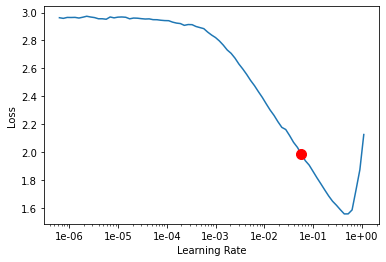

In [ ]:
## 4
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


epoch,train_loss,valid_loss,accuracy,time
0,0.037619,0.028997,0.994435,28:05
1,0.033821,0.032931,0.993600,27:43
2,0.047395,0.023642,0.995548,28:20
3,0.051940,1.689681,0.992766,27:15
4,0.039973,0.033630,0.994713,28:04


Epoch 5: early stopping
3593
Accuracy: 
0.9952685777901475
[('manik_bandhopaddhay', 'tarashonkor'), ('bongkim', 'robindronath'), ('humayun_ahmed', 'shorotchandra'), ('nihar_ronjon_gupta', 'shomresh'), ('shirshendu', 'shottojit_roy'), ('shirshendu', 'shordindu'), ('tarashonkor', 'toslima_nasrin'), ('tarashonkor', 'toslima_nasrin'), ('tarashonkor', 'toslima_nasrin'), ('tarashonkor', 'toslima_nasrin'), ('tarashonkor', 'nihar_ronjon_gupta'), ('tarashonkor', 'nihar_ronjon_gupta'), ('tarashonkor', 'toslima_nasrin'), ('tarashonkor', 'shordindu'), ('tarashonkor', 'toslima_nasrin'), ('humayun_ahmed', 'shunil_gongopaddhay'), ('shirshendu', 'shottojit_roy')]
0.9952685777901475 0.9952466291728287


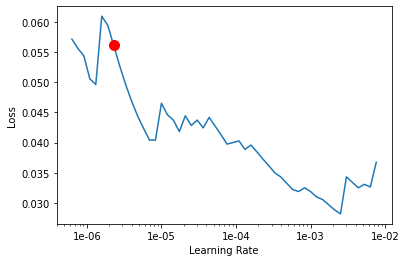

In [ ]:
# 4 continued
train_index, test_index = next(splits)
train_one_split(train_index, test_index, skip_first=True, min_grad_lr=5.75E-02)

TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.157617,0.044902,0.989149,13:55
1,0.074024,0.041804,0.991374,14:10


epoch,train_loss,valid_loss,accuracy,time
0,0.150769,0.072789,0.980245,16:28
1,0.040718,0.027392,0.994992,16:39


epoch,train_loss,valid_loss,accuracy,time
0,0.189590,0.141046,0.963272,23:26
1,0.036253,0.024505,0.996105,24:05


Saved 6 epoch checkpoint.


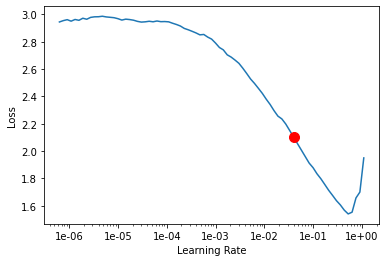

In [16]:
## 5
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


Loaded 6 epoch checkpoint. The following epochs will follow early stopping mechanism, upto a maximum of 20 epochs.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.042581,0.049316,0.988592,30:11
1,0.031566,0.046780,0.989705,30:49
2,0.028438,0.137192,0.987479,29:53


epoch,train_loss,valid_loss,accuracy,time
0,0.042581,0.049316,0.988592,30:11
1,0.031566,0.046780,0.989705,30:49
2,0.028438,0.137192,0.987479,29:53
3,0.041859,0.064452,0.987757,30:15


Epoch 4: early stopping
3593
Accuracy: 
0.9827442248817144
[('manik_bandhopaddhay', 'MZI'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'shorotchandra'), ('bongkim', 'robindronath'), ('bongkim', 'shorotchandra'), ('bongkim', 'shordindu'), ('bongkim', 'shordindu'), ('bongkim', 'shorotchandra'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'shordindu'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'shorotchandra'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'robindronath'), ('bongkim', 'r

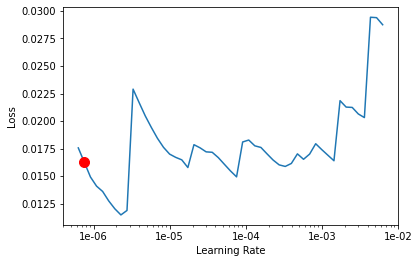

In [17]:
train_one_split(train_index, test_index, skip_first=True)

In [18]:
accuracies = [0.994991652754591 ,0.9938786867000556 ,0.9961035346507097 ,0.9952685777901475, 0.9827442248817144 ]
f1_scores = [0.9949908150139755,0.993805725572687,0.9961026238608149,0.9952466291728287, 0.9818854442157423]

In [19]:
np.array(accuracies).mean(), np.array(f1_scores).mean()

(0.9925973353554436, 0.9924062475672096)